In [46]:
import numpy as np
import pandas as pd


#Wczytujemy dane do słownika
df = pd.read_excel('GA_task.xlsx')
part_processing_data = {}
for i in range(0, 100, 2):
    part_processing_data[i/2] = {
        'R' : list(df[f'Unnamed: {i}'][1:]),
        "T" : list(df[f'Unnamed: {i+1}'][1:])
    }
    

In [47]:
import random


class WorkSchedule():
    def __init__(self, part_processing_data) -> None:
        self.part_processing_data = part_processing_data
        all_queues = self.create_queues_for_mashines()
        all_randomized_queues = self.randomize_queues(all_queues)
        self.all_sorted_queues = self.sort_queues(all_randomized_queues)
        self.all_sorted_queues = self.add_machine_number(self.all_sorted_queues)
        self.all_sorted_queues = self.add_timestamp(self.all_sorted_queues)

    #zostaje stworzona lista list odpowiedające każdej z maszyn, każda posiada swoją kolejkę zadań
    #Maszyny są numerowane od 0!!!!
    def create_queues_for_mashines(self):
        all_queues = [[] for _ in range(10)]
        for part_number in range(50): #self.part_processing_data
            part_schedule = self.part_processing_data[part_number]
            for rank in range(len(self.part_processing_data[part_number]['T'])):
                time = part_schedule['T'][rank]
                machine = part_schedule['R'][rank] - 1
                all_queues[machine].append([(part_number, rank), time])
        return all_queues
    
    def add_machine_number(self, all_queues):
        for i, queue in enumerate(all_queues):
            queue.append(i)
            all_queues[i] = queue
        return all_queues
    
    def add_timestamp(self, all_queues):
        for i, queue in enumerate(all_queues):
            queue.append(0)
            all_queues[i] = queue
        return all_queues
    
    #tasujemy kolejność wykonywania zadań
    def randomize_queues(self, all_queues):
        for machine_number in range(10):
            random.shuffle(all_queues[machine_number])
        return all_queues

    #sortujemy kolejność zadań na podstawie kolejności obróbki detalu
    def sort_queues(self, all_queues):
        for machine_number in range(10):
            sorted_queue = sorted(all_queues[machine_number], key=lambda x: x[0][1])
            all_queues[machine_number] = sorted_queue
        return all_queues
    
    def get_machine_queue(self, machine_number):
        return self.all_sorted_queues[machine_number]
    
    def get_all_machines_queues(self):
        return self.all_sorted_queues
    


[[[(23, 0), 50], [(44, 0), 47], [(33, 0), 18], [(26, 0), 11], [(30, 1), 29], [(24, 1), 28], [(26, 1), 14], [(17, 1), 31], [(48, 1), 39], [(15, 1), 21], [(22, 2), 42], [(0, 2), 47], [(33, 2), 29], [(31, 2), 11], [(7, 2), 36], [(14, 2), 14], [(19, 2), 11], [(9, 2), 20], [(2, 2), 18], [(43, 3), 45], [(44, 3), 15], [(38, 3), 10], [(27, 3), 20], [(24, 4), 27], [(41, 4), 31], [(48, 4), 20], [(17, 4), 47], [(12, 5), 11], [(13, 5), 38], [(27, 5), 23], [(4, 5), 29], [(39, 5), 17], [(37, 5), 18], [(35, 5), 49], [(37, 6), 22], [(39, 6), 42], [(36, 6), 45], [(10, 6), 14], [(25, 6), 21], [(21, 6), 16], [(15, 7), 10], [(3, 7), 10], [(25, 7), 49], [(44, 7), 16], [(31, 8), 18], [(1, 8), 15], [(10, 8), 16], [(21, 8), 20], [(40, 8), 32], [(3, 8), 35], [(27, 9), 38], [(21, 9), 16], [(2, 9), 29], [(32, 9), 17], [(4, 9), 12], [(2, 10), 26], [(13, 10), 13], [(48, 10), 19], [(14, 10), 30], [(44, 10), 24], [(25, 10), 34], [(36, 10), 12], [(38, 10), 23], [(10, 10), 45], [(33, 10), 34], [(15, 10), 29], 0, 0], [

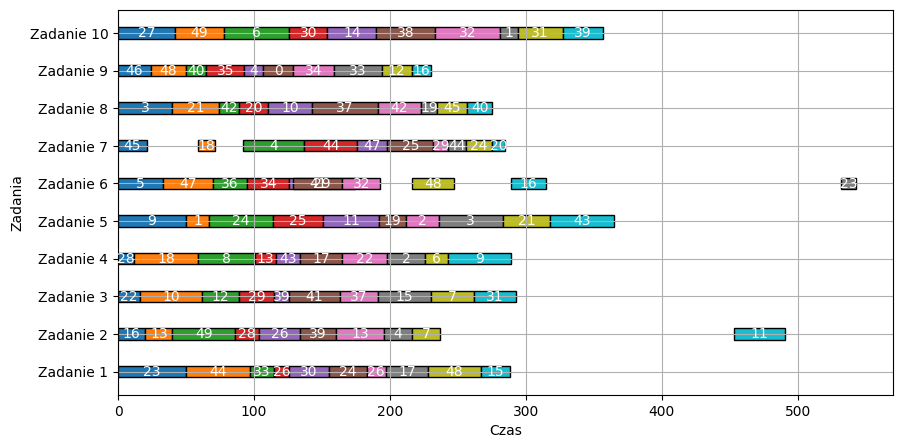

In [48]:
import matplotlib.pyplot as plt


class GanttGraph():
    def __init__(self) -> None:
        self.recent_time_stamps = [0]*10
        self.timetable_for_machines = [[] for _ in range(10)]

    def create_timetables(self, all_sorted_queues):
        for operation_number in range(10):
            # for i, queue in enumerate(all_sorted_queues):
            #     if len(queue) == operation_number + 1:
            #         all_sorted_queues.pop(i)
            #sortowanie po numerze części
            queues_sorted_by_order_of_parts = self.sort_by_order_of_parts(all_sorted_queues, operation_number)
            last_part_number = -1
            #tworzymy listę aktywnych maszyn, sprawdzamy czy maszyna jest na liście aktywnych maszyn
            active_machines = []
            for queue in queues_sorted_by_order_of_parts:
                active_machines.append(queue[-2])
            for number_from_top_list in range(len(active_machines)):
                active_machine = active_machines[number_from_top_list]
                current_operation = queues_sorted_by_order_of_parts[number_from_top_list][operation_number]
                time_of_operation = current_operation[1]
                current_part_number = current_operation[0][0]
                recent_timestamp = queues_sorted_by_order_of_parts[number_from_top_list][-1]
                #jeśli na następnych maszynach obróbka tej samej części to przerwa jest uwzględniania w else
                if current_part_number != last_part_number:
                    self.timetable_for_machines[active_machine].append((recent_timestamp, recent_timestamp+time_of_operation, current_part_number))
                    new_timestamp = recent_timestamp + time_of_operation
                    queues_sorted_by_order_of_parts[number_from_top_list][-1] = new_timestamp
                else:
                    deadline_of_necessary_operation = self.timetable_for_machines[number_from_top_list-1][-1][1]
                    self.timetable_for_machines[active_machine].append((deadline_of_necessary_operation, deadline_of_necessary_operation+time_of_operation, current_part_number))
                    new_timestamp = recent_timestamp + ((deadline_of_necessary_operation+time_of_operation) - self.recent_time_stamps[number_from_top_list])
                    queues_sorted_by_order_of_parts[number_from_top_list][-1] = new_timestamp
                last_part_number = current_part_number
        return self.timetable_for_machines

    def sort_by_order_of_parts(self, all_sorted_queues, i):
        queues_sorted_by_order_of_parts = sorted(all_sorted_queues, key=lambda x: x[i][0])
        return queues_sorted_by_order_of_parts
    
    def draw_graph(self, timetable_for_machines):
        fig, ax = plt.subplots(figsize=(10, len(timetable_for_machines)*0.5))

        for i, task in enumerate(timetable_for_machines):
            for start, end, worker_id in task:
                ax.barh(i, width=(end-start), left=start, height=0.3, align='center', edgecolor='k')
                ax.text(start + (end-start)/2, i, str(worker_id), ha='center', va='center', color='white')

        ax.set_xlabel('Czas')
        ax.set_ylabel('Zadania')
        ax.set_yticks(range(len(timetable_for_machines)))
        ax.set_yticklabels([f'Zadanie {i+1}' for i in range(len(timetable_for_machines))])
        ax.grid(True)

        plt.show()

work_schedule = WorkSchedule(part_processing_data)
all_machines_queues = work_schedule.get_all_machines_queues()
print(all_machines_queues)
gantt_graph = GanttGraph()
timetable_for_machines = gantt_graph.create_timetables(all_machines_queues)
gantt_graph.draw_graph(timetable_for_machines)